In [1]:
import cv2
import mediapipe as mp
import pandas as pd

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

## Helper Function

mark_false improves performance of the pose estimation by marking the image as not writeable to pass by reference

In [5]:
def mark_false(image, pose):
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    return results

## Prepare the DataFrame

In [6]:
annotated = pd.read_csv("annotated.csv", index_col = 0)

In [7]:
coordinates = pd.read_csv("coordinates.csv", index_col = 0)

In [8]:
# reading csv file for the current blazepose_coordinates 
data = pd.read_csv("blazepose_coordinates_main.csv", index_col = 0)

## Data Preprocessing

In [9]:
#### NEW CLASSES HERE ####

# Excersices can be broadly categorized as: https://www.livestrong.com/article/534321-five-types-of-fitness-training/
## High intensity/speed
aerobic = ['jump_rope','jumping_jacks','dancing','jumping', 'x_jumps', 'running', 'all_fours_warm_up',
  'skii_hops','squat_jumps', 'lateral_squad_jumps','lateral_squat_jumps','lateral_shuffle','walking']

coordination_agility = ['agility_feet', 'run_in_place','standing_skips','high_knees', 
  'mountain_climbers','mountain_climber','boxing','high_knee_sprints','high_knee_sprint', 
  'burpy_crawl_combo','burpy', 'pace_skips', 'criss_cross','cross_crunches','surfer_hops',
  'split_hop','lower_knee_hop'] # Could also fit in as a subclass of aerobic activities
# Could maybe also fit in with calisthenics?: 'burpy_crawl_combo','burpy'

## NOTE: Uncomment if combining coordination_agility with aerobic
# [aerobic.append(item) for item in coordination_agility]

## Medium intensity/speed and lifting 
# each below are subtypes of strength training (can use uniquely or put under strength training)
weight_bearing = ['bodyweight_squats','lateral_lunges','lunges','squats','body_weight_squats',
  'lateral_squat_walk_reverse_lundge','squat_hold_reverse_lundge','lateral_squat_walk_reverse_lundge',
  'body_weight_squat_toes','drop_squats']

#non_wieght_bearing = ['torso_up_double_leg_extension', 'hamstring_curl_right','hamstring_curl_left'] # (aka prone strength training)

calisthenics = ['knees_to_elbow', 'loaded_beast_push_up','modified_push_ups','crunches','pushups',
   'pullups','wall_pushups','pulse_ups_right','pulse_ups_left','straight_left_leg_pulse'] # (bodyweight excersizes)

weightlifting = ['bench_press','triceps','donkey_press','front_press','front_up_pulse']

## NOTE: Uncomment below if combining above classes into single strength training class
# comb_list =[weight_bearing, non_wieght_bearing, calisthenics, weightlifting]
# strength_training = [item for sublist in comb_list for item in sublist] # flat strength training list if single class preferred.

##### Lower intensity/speed (flexibility, stability) ######
balance_stability = ['bear_hold_knee_taps','bear_hold_shoulder_taps','bear_hold',
  'fullbody_walkouts', 'lay_down_knees_up', 'lay_down_one_knee_up','lay_down_knee_up_down',
  'lay_down_knee_swing_shoulder_blades_up','fire_hydrants','roll_up','alternating_deadbug',
  'single_bent_leg_lower','double_bent_leg_lower', 'double_leg_extension', 'upper_body_up_criss_cross',
  'bear_hold_taps','bear_crawl','forward_plank','left_side_plank','right_side_plank','arm_plank',
  'modified_arm_plank','left_side_plank_reaching','right_side_plank_reaching','kickbacks_right_glute',
  'straight_right_leg_pulse','kickbacks_left_glute','hip_bridge','forearm_plank','high_plank',
  'high_plank_right_leg_press','push_hip_up_right_leg','push_hip_up_left_leg','high_plank_shoulder_feet_combo',
  'straight_leg_lifts','push_hip_up_right_leg_up','hip_up_right_swing_down','push_hip_up_left_leg_up','hip_up_left_swing_down',
  'high_plank_left_leg_press','reverse_dog_crunch', 'all_fours_drive','forearm_plank_rocking','upper_body_up_double_leg_extension',
  'front_laying_leg_lifts','front_laying_arms_legs_lifts','plank_dynamic','plank_static','side_plank_dynamic','plank']
# Could fit in elsewhere also (calisthenics): alternating_deadbug, fire_hydrants, kickbacks_right_glute, 

flexibility = ['yoga,stretching','streching','yoga,','yoga,ground','yoga,all_four','yoga,standing'
  'strech','stretching', 'down_dog','up_dog','runners_lundge_reach','table_top','all_fours',
   'knees_to_chest','cat_cow','all_fours_elbow_spine_stretch','up_down_dog']
# Could be further split into dynamic and static stretches

idle = ['idle','all_fours_idle','standing','standing,talking','talking,walking','talking','standing_idle','standing_writing','walking_idle','kneeling_idle','table_top_position_idle','sitting','sitting_idle' 'laying_flat','laying_down_idle','laydown_faceup','laying_down_face_up','front_laying_position','laying_down_flat','laydown_face_up','laydown_flat','front_laying_idle', 'hanging']
doubt = ['transition','glutes','shuffle_position', 'adjusting','pointing']
remove = ['slides', 'off_screen', 'slide', 'pointing', 'offscreen','intro_page']

In [10]:
def change_actions(x):
    if x in aerobic:
        return 'aerobic'
    elif x in coordination_agility:
        return 'coordination_agility'
    elif x in weight_bearing:
        return 'weight_bearing'
    elif x in calisthenics:
        return 'calisthenics'
    elif x in weightlifting:
        return 'weightlifting'
    elif x in balance_stability:
        return 'balance_stability'
    elif x in flexibility:
        return 'flexibility'
    elif x in remove:
        return 'remove'
    elif x in doubt:
        return "doubt"
    else:
        return 'idle'

In [11]:
def preprocess_data(annotated, data):
    req = annotated.iloc[:,3:].values.tolist()
    flatten = [items for lists in req for items in lists]
    flatten = [x for x in flatten if str(x) != 'nan']
    count_dict={}
    for action in flatten:
        if action in count_dict:
            count_dict[action]+=1
        else:
            count_dict[action]=1

    count = pd.DataFrame.from_dict(count_dict,orient = 'index')
    count.reset_index(inplace=True)
    count = count.rename(columns = {'index':'actions'})
    count['six_class']= count['actions'].apply(lambda x: change_actions(x))
    data['target']= data['actions'].apply(lambda x: change_actions(x))
    data.drop(['actions'] ,axis = 1,inplace = True)
    

In [12]:
preprocess_data(annotated, data)

In [13]:
preprocess_data(annotated, coordinates)

Dropping target value for data(BlazePose) because data and coordinates(MoveNet) has exact same target value and we are going to merge them together

In [14]:
data.drop(['target'] ,axis = 1,inplace = True)

Renaming the feature name because column name overlaps for data and coordinates

In [15]:
re = ['video_id', 'frame_count', 'fps']
for i in range(34):
    re.append(i+99)
re.append('target')


In [16]:
coordinates.columns = re

In [113]:
coordinates

,video_id,frame_count,fps,99,100,101,102,103,104,105,...,124,125,126,127,128,129,130,131,132,target
0,279,1,29,0.194167,0.474421,0.177525,0.486390,0.177479,0.467132,0.190676,...,0.514983,0.620077,0.467754,0.627111,0.503399,0.782260,0.464268,0.773160,0.460820,aerobic
1,279,2,29,0.194559,0.473831,0.179554,0.483210,0.179706,0.468016,0.191008,...,0.516670,0.620963,0.461590,0.638270,0.504532,0.774690,0.468995,0.771903,0.470143,aerobic
2,279,3,29,0.196080,0.468627,0.181912,0.478633,0.180850,0.463631,0.193267,...,0.508290,0.620228,0.462210,0.622819,0.478843,0.778599,0.492166,0.774354,0.489078,aerobic
3,279,4,29,0.196092,0.468655,0.181905,0.478662,0.180863,0.463647,0.193274,...,0.508061,0.619862,0.462096,0.622813,0.479078,0.778002,0.492249,0.774339,0.489007,aerobic
4,279,5,29,0.197715,0.467405,0.184015,0.475692,0.181017,0.464770,0.194321,...,0.515078,0.615721,0.476758,0.614663,0.496875,0.777589,0.512477,0.772853,0.513822,aerobic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559047,1128,1756,29,0.369264,0.427513,0.351490,0.429317,0.354096,0.416672,0.350904,...,0.382743,0.804711,0.445376,0.826067,0.401656,0.954128,0.432958,0.944596,0.415342,aerobic
559048,1128,1757,29,0.369439,0.428200,0.352076,0.429936,0.354834,0.417667,0.352572,...,0.381743,0.807297,0.441704,0.825380,0.399921,0.953517,0.430752,0.940221,0.412758,aerobic
559049,1128,1758,29,0.371266,0.427900,0.353715,0.429250,0.357135,0.417058,0.352838,...,0.379473,0.805639,0.437797,0.826095,0.397931,0.954819,0.430333,0.939026,0.410947,aerobic
559050,1128,1759,29,0.372162,0.427443,0.354611,0.428730,0.358167,0.416442,0.353902,...,0.376918,0.815868,0.436354,0.827735,0.396352,0.957337,0.430134,0.940548,0.411525,aerobic


Merging the data and coordinates together

In [17]:
data = pd.merge(data, coordinates, on=['video_id','frame_count','fps'],how='left')

Looking at the data, there are features from 0 to 132 which are coordinates for MoveNet and BlazePose

In [20]:
data

,video_id,frame_count,fps,0,1,2,3,4,5,6,...,124,125,126,127,128,129,130,131,132,target
0,473.0,1.0,29.0,0.352177,0.398236,-0.289880,0.350398,0.368885,-0.306512,0.353546,...,0.932753,0.639003,0.944321,0.639116,0.941022,0.654382,0.954102,0.655568,0.952701,calisthenics
1,473.0,2.0,29.0,0.350715,0.403618,-0.283021,0.348484,0.374674,-0.298983,0.351593,...,0.931911,0.639285,0.944352,0.640409,0.938109,0.655008,0.953704,0.655566,0.951540,calisthenics
2,473.0,3.0,29.0,0.349499,0.411555,-0.286922,0.346597,0.381458,-0.303021,0.349692,...,0.931960,0.639568,0.944504,0.640681,0.937751,0.655069,0.953819,0.655676,0.951544,calisthenics
3,473.0,4.0,29.0,0.346089,0.416364,-0.303344,0.343975,0.386571,-0.318925,0.347301,...,0.932532,0.638954,0.942544,0.639247,0.940148,0.654153,0.954063,0.655039,0.952489,calisthenics
4,473.0,5.0,29.0,0.342475,0.423968,-0.327087,0.341991,0.393442,-0.342491,0.345512,...,0.932520,0.638494,0.942631,0.638849,0.940112,0.654305,0.954138,0.655318,0.952528,calisthenics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396499,1114.0,139.0,25.0,0.646007,0.316969,-0.061657,0.639735,0.309306,-0.051486,0.638369,...,0.560173,0.662993,0.525069,0.661141,0.542530,0.777789,0.499765,0.776276,0.499883,calisthenics
396500,1114.0,140.0,25.0,0.642752,0.313360,-0.067023,0.636450,0.305557,-0.056860,0.635256,...,0.555198,0.666622,0.532077,0.662377,0.536820,0.777529,0.501835,0.775798,0.497894,calisthenics
396501,1114.0,141.0,25.0,0.642325,0.312570,-0.065557,0.635879,0.304745,-0.055696,0.634685,...,0.559474,0.665680,0.524110,0.665577,0.553889,0.776522,0.499842,0.774876,0.499820,calisthenics
396502,1114.0,142.0,25.0,0.643565,0.313708,-0.061346,0.637264,0.305653,-0.051180,0.636060,...,0.558601,0.665897,0.525437,0.661288,0.569732,0.776825,0.499542,0.774144,0.501197,calisthenics


## Modelling & Get Result

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import stats

# Function to return the diffrence in coordinate of xth frame and x+nth frame
def data_transform(data, n, step, test = False):  
    if test == False:
        segments = []
        labels = []
        video_id = []
        for id in data['video_id'].unique():
            sub_set = data[data["video_id"] == id]
            for i in range(0, sub_set.shape[0] - n, step):
                values = ((sub_set.iloc[i+n, 3:136] - sub_set.iloc[i, 3:136]) / sub_set.iloc[i+n, 3:136])
                label = stats.mode(sub_set['target'][i: i+n])[0][0]
                segments.append([values.append(sub_set.iloc[i+n, 3:136])])
                labels.append(label)
        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,266)
        df = pd.DataFrame(reshaped_segments)
        df['target'] = labels       
        return(df)       
    else:
        segments = []
        data = pd.DataFrame(points) 
        for i in range(0, data.shape[0] - n, step):
            values = ((data.iloc[i+n, :] - data.iloc[i, :]) / data.iloc[i+n, :])
            segments.append([values.append(data.iloc[i+n, :])])
        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,266)
        return(reshaped_segments)

This part is running the merged data to data_transform function which does the feature engineering. 
After, we fill the null values and drop some rows that have wrong target.
Lastly, we split the data into train and test data

In [209]:
from sklearn.model_selection import train_test_split
data_transformed = data_transform(data, 3, 3)
remove_from_target = ['doubt', 'remove']
data_transformed = data_transformed[~data_transformed['target'].isin(remove_from_target)]
data_transformed = data_transformed.fillna(0)
data_transformed = data_transformed[data_transformed.target != 0]
print(data_transformed.groupby("target").size())
X = data_transformed.iloc[:,:-1]
y = data_transformed['target']
from sklearn.preprocessing import LabelEncoder
# changing the target value to numeric value to fit the data
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, shuffle  = True)

target
aerobic                  7496
balance_stability       30514
calisthenics            17024
coordination_agility    17661
flexibility             23539
idle                    17817
weight_bearing          13412
weightlifting            3568
dtype: int64


In [204]:
data_transformed.to_csv("data_transformed_combined.csv") # saving Final data after running data_transformed

In [206]:
data.to_csv("data_combined.csv") # Saving the original data

In [27]:
data_transformed = pd.read_csv("data_transformed_combined.csv", index_col = 0)

In [28]:
data_transformed

,0,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,target
0,-0.017589,0.043538,0.044383,-0.018672,0.045750,0.038923,-0.017982,0.047334,0.038594,-0.017200,...,0.932532,0.638954,0.942544,0.639247,0.940148,0.654153,0.954063,0.655039,0.952489,calisthenics
1,-0.026741,0.052833,0.084456,-0.018287,0.056469,0.083804,-0.018920,0.057455,0.083834,-0.020147,...,0.932421,0.638804,0.942232,0.640165,0.936547,0.653891,0.953920,0.654072,0.951629,calisthenics
2,-0.010826,0.037929,0.065219,-0.016223,0.039091,0.063721,-0.016421,0.038495,0.063759,-0.016729,...,0.932257,0.637842,0.941720,0.639210,0.935848,0.652533,0.952194,0.653947,0.951405,calisthenics
3,-0.004501,0.055088,0.068604,-0.001680,0.051162,0.065520,0.000023,0.050226,0.065455,0.001998,...,0.932365,0.635320,0.941926,0.633525,0.937567,0.650503,0.952504,0.650339,0.951659,calisthenics
4,-0.008753,0.030016,-0.112185,-0.008776,0.038128,-0.110588,-0.009312,0.037334,-0.110587,-0.008623,...,0.446877,0.561877,0.607350,0.565182,0.407890,0.667172,0.648904,0.773725,0.485640,calisthenics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131485,-0.027994,-0.038927,0.994525,-0.027773,-0.033775,1.373878,-0.027379,-0.032492,1.372986,-0.027038,...,0.567548,0.651507,0.584699,0.660709,0.536802,0.763831,0.574982,0.770977,0.499617,calisthenics
131486,-0.027776,-0.030117,0.268969,-0.029705,-0.044688,0.315462,-0.029643,-0.045465,0.315056,-0.029654,...,0.561619,0.650234,0.581719,0.660062,0.534165,0.762255,0.574010,0.773252,0.498762,calisthenics
131487,-0.022797,-0.010816,0.230042,-0.021713,-0.010691,0.272654,-0.021733,-0.010978,0.272811,-0.021720,...,0.554316,0.653404,0.579712,0.658471,0.528459,0.775464,0.504123,0.775387,0.498792,calisthenics
131488,-0.010626,-0.005904,0.080353,-0.012336,-0.004666,0.087149,-0.012955,-0.004789,0.087143,-0.013745,...,0.560173,0.662993,0.525069,0.661141,0.542530,0.777789,0.499765,0.776276,0.499883,calisthenics


In [216]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[100, 500, 1000]}
grid = GridSearchCV(ExtraTreesClassifier(),params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=ExtraTreesClassifier(),
             param_grid={'n_estimators': [100, 500, 1000]})

In [217]:
print(grid.best_params_)
print(grid.score(X_test,y_test))

{'n_estimators': 1000}
0.9796385615727455


We run ExtraTreesClassifier with n_estimators = 1000 based on the hyperparameter tuning that we ran

In [218]:
from sklearn.ensemble import ExtraTreesClassifier
clf_extra = ExtraTreesClassifier(n_estimators = 1000, random_state=42)
clf_extra.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=1000, random_state=42)

ACCURACY PER INSTANCE: 0.9796385615727455
F1_score: 0.9764395296337175
Precision: 0.9796385615727455
Recall: 0.9796385615727455
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1874
           1       0.99      1.00      0.99      7629
           2       0.99      0.98      0.99      4256
           3       0.97      0.97      0.97      4415
           4       0.99      0.99      0.99      5885
           5       0.96      0.96      0.96      4454
           6       0.97      0.98      0.98      3353
           7       0.98      0.97      0.97       892

    accuracy                           0.98     32758
   macro avg       0.98      0.97      0.98     32758
weighted avg       0.98      0.98      0.98     32758



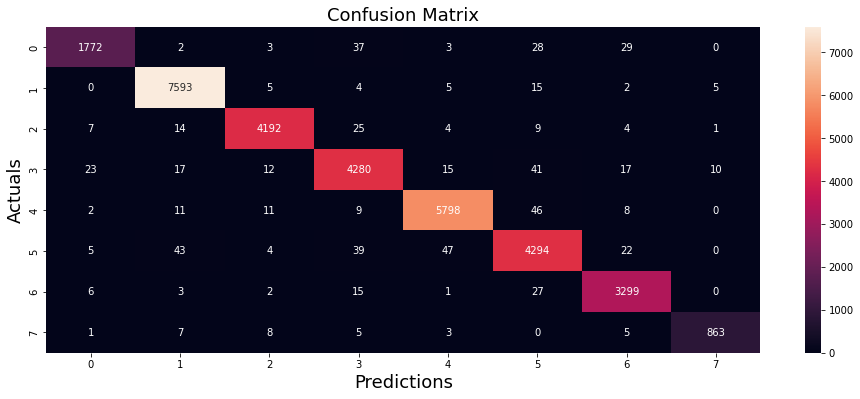

In [223]:
predictions  = clf_extra.predict(X_test) 
preds_probs = clf_extra.predict_proba(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='macro')
precision = precision_score(y_test, predictions,average = 'micro', pos_label=1)
recall = recall_score(y_test, predictions,average = 'micro', pos_label=1)
print("ACCURACY PER INSTANCE:" ,accuracy)
print("F1_score:" ,f1)
print("Precision:", precision)
print("Recall:",recall)  
(unique,count) = np.unique(y_train, return_counts=True)
class_labels = unique
plt.figure(figsize = (16,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test , predictions)),annot=True, fmt="d",
            xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
print(classification_report(y_test, predictions))
plt.show()

Saving and loading the model

In [224]:
import pickle
filename = "combined_extratrees.sav"
pickle.dump(clf_extra, open(filename, 'wb'))

In [222]:
import pickle
clf_extra = pickle.load(open('extraTrees_model.sav', 'rb'))